# Libraries

In [20]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl

#for sensor
import serial
import re

#for webpage reading
import requests

# Fuzzy Input/Output Variables

In [21]:
# Inputs
temperature = ctrl.Antecedent(np.arange(-44, 86, 1), 'temperature')      # °C
humidity = ctrl.Antecedent(np.arange(0, 101, 1), 'humidity')     # %
feeling = ctrl.Antecedent(np.arange(0, 11, 1), 'feeling')        # 0=cold ... 10=hot
ecology = ctrl.Antecedent(np.arange(0, 11, 1), 'ecology')        # 0=very ecologically concerned ... 10=not concerned by ecology

# Output
heat = ctrl.Consequent(np.arange(0, 51, 1), 'heat')       # heating level °C

# It's gonna show us to which temperature we should heat/cool the room.

# Membership Functions

In [22]:
room = 'living room'

In [23]:
def temp_membership_func(var, b1, c1, s1, m1, s2, m2, s3 ,m3, b2, c2):
    # for the b parameter we set the mean of our data and for c the standard deviation, even though this is not totally accurate and we would need a curve fitting, we think these are relatively acceptable parameters
    var['too cold']    = fuzz.sigmf(var.universe, b=b1,  c=-c1)
    var['chilly']    = fuzz.gaussmf(var.universe, sigma=s1,  mean=m1)
    var['comfortable']  = fuzz.gaussmf(var.universe, sigma=s2,  mean=m2)
    var['rather hot']     = fuzz.gaussmf(var.universe, sigma=s3,  mean=m3)
    var['too hot']     = fuzz.sigmf(var.universe, b=b2,  c=c2)


In [24]:
if room == 'bathroom':
    temp_membership_func(temperature, 15.38, 2.73, 2.60, 17.75, 1.91, 21.75, 2.10, 25.88, 28.68, 1.69)
    temp_membership_func(heat, 15.38, 2.73, 2.60, 17.75, 1.91, 21.75, 2.10, 25.88, 28.68, 1.69)

elif room == 'kitchen':
    temp_membership_func(temperature, 12.75, 3.49, 3.14, 16.88, 3.55, 21.00, 3.98, 25.19, 28.25, 4.37)
    temp_membership_func(heat, 12.75, 3.49, 3.14, 16.88, 3.55, 21.00, 3.98, 25.19, 28.25, 4.37)

elif room == 'bedroom':
    temp_membership_func(temperature, 13.39, 4.68, 4.06, 15.59, 3.08, 18.83, 2.76, 23.11, 25.08, 2.46)
    temp_membership_func(heat, 13.39, 4.68, 4.06, 15.59, 3.08, 18.83, 2.76, 23.11, 25.08, 2.46)

#else: # room in living room or any other room (standard)
#    temp_membership_func(temperature, 13.00, 3.16, 2.67, 17.62, 2.91, 21.07, 4.49, 26.77, 29.50, 4.66)
#    temp_membership_func(heat, 13.00, 3.16, 2.67, 17.62, 2.91, 21.07, 4.49, 26.77, 29.50, 4.66)

else: # room in living room or any other room (standard)
    temp_membership_func(temperature, 13.00, 3.16, 2.67, 17.62, 2.91, 21.07, 1.49, 26.77, 29.50, 4.66)
    temp_membership_func(heat, 13.00, 3.16, 2.67, 17.62, 2.91, 21.07, 1.49, 26.77, 29.50, 4.66)



# according to https://atmotube.com/blog/ideal-household-humidity-level, a good humidity for inside is 40-50% --> 45% should be optimal
humidity['low']    = fuzz.trapmf(humidity.universe, [0, 0, 0, 45])
humidity['ok']     = fuzz.trimf(humidity.universe, [0, 45, 100])
humidity['high']   = fuzz.trapmf(humidity.universe, [45, 100, 100, 100])

feeling['too cold']    = fuzz.trapmf(feeling.universe, [0, 0, 0, 5])
feeling['okay']   = fuzz.trimf(feeling.universe, [0, 5, 10])
feeling['too hot']     = fuzz.trapmf(feeling.universe, [5, 10, 10, 10])

ecology['not eco']    = fuzz.trapmf(ecology.universe, [0, 0, 0, 5])
ecology['medium']   = fuzz.trimf(ecology.universe, [0, 5, 10])
ecology['eco']     = fuzz.trapmf(ecology.universe, [5, 10, 10, 10])




c:\Users\marta\anaconda3\ana\envs\FuzzyHeat\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


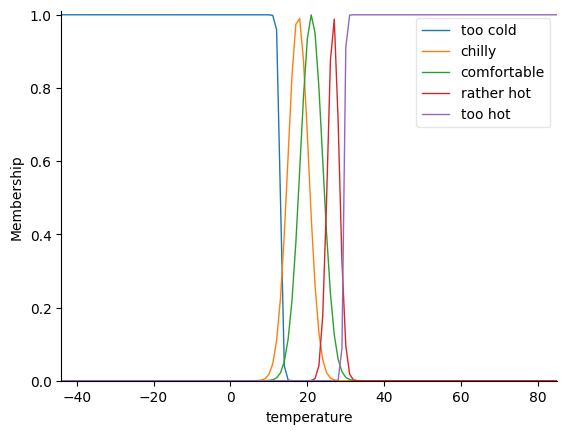

In [25]:
temperature.view()

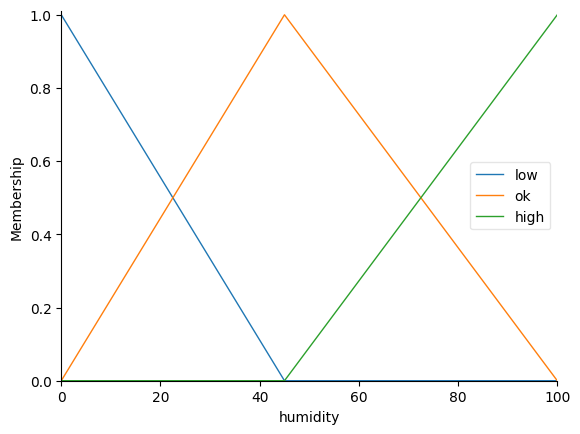

In [26]:
humidity.view()

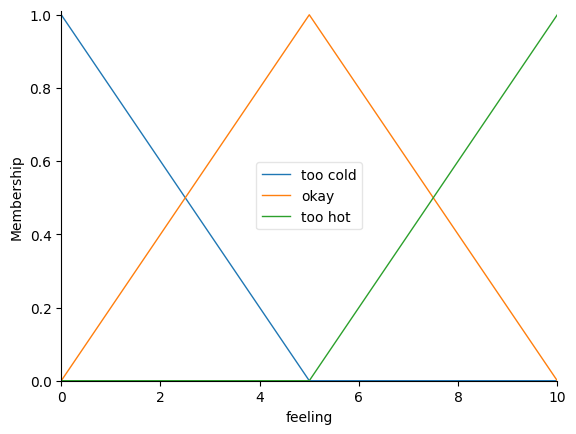

In [27]:
feeling.view()

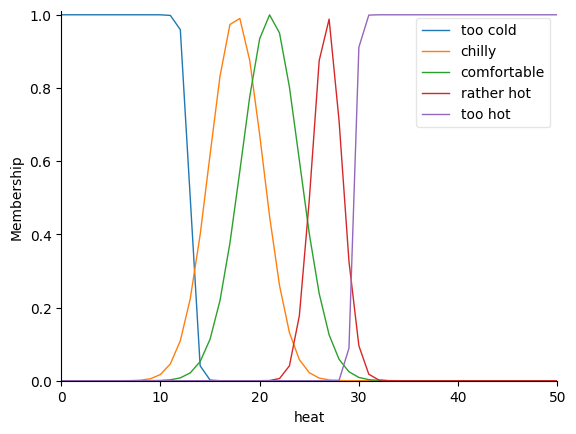

In [28]:
heat.view()

# Rules

In [29]:
### test 1
r1 = ctrl.Rule(temperature['too hot'], heat['chilly'])
r2 = ctrl.Rule(temperature['too cold'], heat['rather hot'])
r3 = ctrl.Rule(temperature['rather hot'] & ecology['not eco'], heat['chilly'])
r4 = ctrl. Rule(temperature['rather hot'] & ecology['eco'], heat['comfortable'])
r5 = ctrl. Rule(temperature['chilly'] & ecology['eco'], heat['comfortable'])
r6 = ctrl. Rule(temperature['chilly'] & ecology['not eco'], heat['rather hot'])

r7=ctrl.Rule(feeling['too hot'], heat['chilly'])
r8=ctrl.Rule(feeling['okay'], heat['comfortable'])
r9=ctrl.Rule(feeling['too cold'], heat['rather hot'])

heating_ctrl = ctrl.ControlSystem([r1,r2,r3,r4,r5,r6,r7,r8,r9])
heating_sim = ctrl.ControlSystemSimulation(heating_ctrl)

In [30]:
# test 2
r1 = ctrl.Rule(temperature['too hot'], heat['chilly'])
r2 = ctrl.Rule(temperature['too cold'], heat['rather hot'])

r3 = ctrl.Rule(temperature['rather hot'] & ecology['not eco'] & feeling['okay'], heat['comfortable'])
r4 = ctrl. Rule(temperature['rather hot'] & ecology['eco'] & feeling['okay'], heat['rather hot'])

r3b = ctrl.Rule(temperature['rather hot'] & ecology['not eco'] & feeling['too hot'], heat['chilly'])
r4b = ctrl.Rule(temperature['rather hot'] & ecology['eco'] & feeling['too hot'], heat['rather hot'])

r5 = ctrl. Rule(temperature['chilly'] & ecology['eco'] & feeling['okay'], heat['chilly'])
r6 = ctrl. Rule(temperature['chilly'] & ecology['not eco'] & feeling['okay'], heat['comfortable'])

r5b = ctrl. Rule(temperature['chilly'] & ecology['eco'] & feeling['too cold'], heat['chilly'])
r6b = ctrl. Rule(temperature['chilly'] & ecology['not eco'] & feeling['too cold'], heat['rather hot'])



r7=ctrl.Rule(feeling['too hot'], heat['chilly'])
r8=ctrl.Rule(feeling['okay'], heat['comfortable'])
r9=ctrl.Rule(feeling['too cold'], heat['rather hot'])

heating_ctrl = ctrl.ControlSystem([r1,r2,r3,r3b, r4b, r4,r5,r6,r7,r8,r9])
heating_sim = ctrl.ControlSystemSimulation(heating_ctrl)

In [31]:
# my best so far

r1 = ctrl.Rule(temperature['too hot'], heat['chilly'])
r2 = ctrl.Rule(temperature['too cold'], heat['rather hot'])

r3 = ctrl. Rule(temperature['chilly'] & feeling['too cold'], heat['rather hot'])
r4 = ctrl. Rule(temperature['chilly'] & feeling['too hot'], heat['too cold'])
r5 = ctrl. Rule(temperature['rather hot'] & feeling['too cold'], heat['too hot'])
r6 = ctrl. Rule(temperature['rather hot'] & feeling['too hot'], heat['chilly'])
r7 = ctrl. Rule(temperature['chilly'] & feeling['okay'], heat['chilly'])
r8 = ctrl. Rule(temperature['rather hot'] & feeling['okay'], heat['rather hot'])
r9 = ctrl. Rule(temperature['comfortable'] & feeling['too hot'], heat['chilly'])
r10 = ctrl. Rule(temperature['comfortable'] & feeling['okay'], heat['comfortable'])
r11 = ctrl. Rule(temperature['comfortable'] & feeling['too cold'], heat['rather hot'])

r12 = ctrl. Rule((temperature['too cold'] | temperature['chilly']) & ecology['eco'], heat['chilly'])
r13 = ctrl. Rule((temperature['too hot'] | temperature['rather hot']) & ecology['eco'], heat['rather hot'])
r14 = ctrl. Rule((temperature['too cold'] | temperature['chilly']) & ecology['medium'], heat['comfortable'])
r15 = ctrl. Rule((temperature['too hot'] | temperature['rather hot']) & ecology['medium'], heat['comfortable'])
r16 = ctrl. Rule((temperature['too cold'] | temperature['chilly']) & ecology['not eco'], heat['rather hot'])
r17 = ctrl. Rule((temperature['too hot'] | temperature['rather hot']) & ecology['not eco'], heat['chilly'])

heating_ctrl = ctrl.ControlSystem([r1,r2,r3,r4,r5,r6,r7,r8,r9,r10,r11,r12,r13,r14,r15,r16,r17])
heating_sim = ctrl.ControlSystemSimulation(heating_ctrl)


In [40]:
# ===== TEST SIMULATION EXAMPLE =====

# Example scenario:
# - living room, membership already defined above
# - temperature: 18°C (a bit cold)
# - humidity: 60% (slightly humid)
# - feeling: 3/10 (closer to 'too cold' region, but overlapping with 'okay')
# - ecology: 2/10 (eco-friendly)

#get sensor's records from flask API

sensor = requests.get("http://localhost:5000/data").json()

t = sensor["temperature"]
h = sensor["humidity"]

print("Sensor:", sensor)

sliders = requests.get("http://localhost:5000/sliders").json()

feeling = sliders["feeling"]
ecology = sliders["ecology"]

print("Sliders:", sliders)


heating_sim.input['temperature'] = t
#heating_sim.input['humidity'] = 60
heating_sim.input['feeling'] = 3
heating_sim.input['ecology'] = 2

heating_sim.compute()
print("actual temperature", t  , "Computed heat output:", heating_sim.output['heat'])

Sensor: {'altitude': 558.95, 'humidity': 55.52, 'pressure': 947.89, 'temperature': 22.82}
Sliders: {'ecology': 6, 'feeling': 7}
actual temperature 22.82 Computed heat output: 23.18097835421743


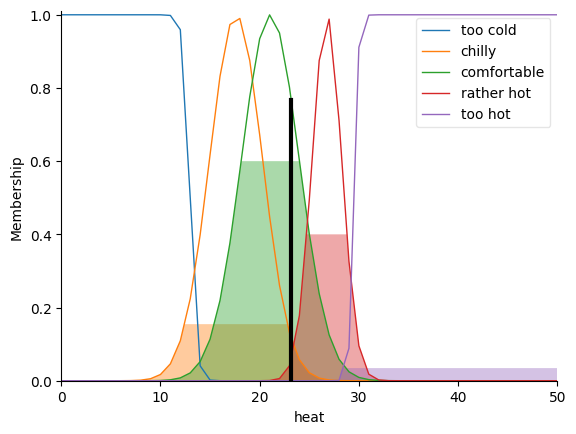

In [41]:
heat.view(sim=heating_sim)

In [10]:
# FUZZY RULE SET 

# A) User feels too cold
rule1  = ctrl.Rule(feeling['too cold'] & ecology['not eco'], heat['too hot'])
rule2  = ctrl.Rule(feeling['too cold'] & ecology['medium'], heat['rather hot'])
rule3  = ctrl.Rule(feeling['too cold'] & ecology['eco'], heat['comfortable'])

# B) User feels "okay" (covers slightly cold / comfortable region)
rule4  = ctrl.Rule(feeling['okay'] & ecology['not eco'],heat['rather hot'])
rule5  = ctrl.Rule(feeling['okay'] & ecology['medium'], heat['comfortable'])
rule6  = ctrl.Rule(feeling['okay'] & ecology['eco'], heat['chilly'])

# Extra sensor influence (temperature + humidity)
rule7  = ctrl.Rule(temperature['too cold'] & feeling['okay'], heat['rather hot'])
rule8  = ctrl.Rule(temperature['chilly'] & humidity['high'] & feeling['okay'], heat['comfortable'])

# C) User feels okay + temperature context
rule9  = ctrl.Rule(feeling['okay'] & temperature['comfortable'] & ecology['not eco'], heat['chilly'])
rule10 = ctrl.Rule(feeling['okay'] & temperature['comfortable'] & ecology['eco'], heat['too cold'])
rule11 = ctrl.Rule(feeling['okay'] & temperature['chilly'], heat['comfortable'])
rule12 = ctrl.Rule(feeling['okay'] & temperature['rather hot'], heat['too cold'])

# D) User feels too hot
rule13 = ctrl.Rule(feeling['too hot'],heat['too cold'])

# Supporting rules: extreme temperature
rule14 = ctrl.Rule(temperature['too hot'], heat['too cold'])
rule15 = ctrl.Rule(temperature['rather hot'] & humidity['high'], heat['too cold'])

# E) Strong ecology influence (global brake)
rule16 = ctrl.Rule(ecology['eco'] & temperature['comfortable'] & feeling['okay'], heat['chilly'])
rule17 = ctrl.Rule(ecology['eco'] & feeling['okay'], heat['too cold'])

# Build control system
heating_ctrl = ctrl.ControlSystem([
    rule1, rule2, rule3,
    rule4, rule5, rule6,
    rule7, rule8,
    rule9, rule10, rule11, rule12,
    rule13,
    rule14, rule15,
    rule16, rule17
])

heating_sim = ctrl.ControlSystemSimulation(heating_ctrl)

# System and Helper Function

In [11]:
# ===== TEST SIMULATION EXAMPLE =====

# Example scenario:
# - living room, membership already defined above
# - temperature: 18°C (a bit cold)
# - humidity: 60% (slightly humid)
# - feeling: 3/10 (closer to 'too cold' region, but overlapping with 'okay')
# - ecology: 2/10 (eco-friendly)

heating_sim.input['temperature'] = 18
heating_sim.input['humidity'] = 60
heating_sim.input['feeling'] = 3
heating_sim.input['ecology'] = 2

heating_sim.compute()
print("Computed heat output:", heating_sim.output['heat'])

Computed heat output: 16.357136236575844


In [ ]:
###### to adapt
system = ctrl.ControlSystem(rules)
sim = ctrl.ControlSystemSimulation(system)
# Our system 
def fuzzy_heating(temp_c, humid_pct, feel_scale):
    sim.input['temp'] = float(temp_c)
    sim.input['humid'] = float(humid_pct)
    sim.input['feel'] = float(feel_scale)
    sim.compute()
    return sim.output['heat']
# Showing the outputs in categories
def heat_category(value):
    if value < 20:
        return "Off"
    elif value < 40:
        return "Low"
    elif value < 70:
        return "Medium"
    else:
        return "High"



# Some Tests

In [ ]:
######### to adapt

tests = [
    (18, 40, 2),   # cold room, feels cold
    (23, 50, 5),   # comfy
    (15, 70, 2),   # cold + high humidity
    (12, 30, 1),   # very cold
    (26, 55, 8),   # hot
]

for t,h,f in tests:
    heat_val = fuzzy_heating(t,h,f)
    print(f"Input: temp={t}°C, humid={h}%, feel={f} "
          f"→ heat={heat_val:.1f} ({heat_category(heat_val)})")


Input: temp=18°C, humid=40%, feel=2 → heat=55.0 (Medium)
Input: temp=23°C, humid=50%, feel=5 → heat=9.4 (Off)
Input: temp=15°C, humid=70%, feel=2 → heat=71.6 (High)
Input: temp=12°C, humid=30%, feel=1 → heat=85.9 (High)
Input: temp=26°C, humid=55%, feel=8 → heat=7.8 (Off)


In [ ]:
# ===== TEST SIMULATION EXAMPLE =====

# Example scenario:
# - living room, membership already defined above
# - temperature: 18°C (a bit cold)
# - humidity: 60% (slightly humid)
# - feeling: 3/10 (closer to 'too cold' region, but overlapping with 'okay')
# - ecology: 2/10 (eco-friendly)

heating_sim.input['temperature'] = 18
heating_sim.input['humidity'] = 60
heating_sim.input['feeling'] = 3
heating_sim.input['ecology'] = 2

heating_sim.compute()
print("Computed heat output:", heating_sim.output['heat'])